# **Lightweight CNN Model**

**Goal:** The lightweight CNN model is designed to detect patterns in the encoded feature vectors from IoT network data.

**CNN model:** The model uses 1D convolutional layers to slide small filters across the input, identifying local dependencies between features that may indicate DDoS attacks. Max pooling layers follow each convolution to reduce dimensionality and highlight the most important features, making the model faster and less prone to overfitting. After flattening, the data passes through a small fully connected layer with dropout for regularization, followed by a sigmoid-activated output layer that produces a probability for binary classification. This structure balances accuracy and speed, making it well-suited for deployment on resource-limited IoT devices.

**Loss Function and Optimizer:** We use nn.BCELoss() as the loss function and the Adam optimizer to train the CNN. Binary Cross Entropy Loss is well-suited for binary classification tasks like DDoS detection, where the model outputs a probability between 0 and 1 indicating whether a given network input represents an attack. The Adam optimizer is chosen because it adapts the learning rate for each parameter individually, leading to faster and more stable convergence, which is important when training on large, complex datasets. This combination of loss function and optimizer balances efficiency and performance.

A learning rate of 1e-3 was chosen because it is a commonly used default for the Adam optimizer and generally provides a good balance between fast convergence and stable learning. Because the input data is reduced and normalized, the gradients tend to be well-behaved, making 1e-3 a safe and effective choice for this binary classification task.

**Training:** We set the number of training epochs to 20 as a reasonable upper limit, given the lightweight nature of the CNN and the expectation that the model would converge relatively quickly. To avoid overfitting and unnecessary training, we implemented early stopping with a patience of 3 epochs, meaning training stops if the validation loss doesn't improve for three consecutive epochs. This approach helps ensure efficient training while maintaining model generalization.

In [2]:
# Libraries

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning framework
import torch
import torch.nn as nn                   # For building neural network layers
import torch.nn.functional as F        # For activation functions and loss
from torch.utils.data import DataLoader, TensorDataset  # For batching and dataset handling
import torch.optim as optim            # For optimizers

# Model evaluation
from sklearn.model_selection import train_test_split    # For splitting data
from sklearn.metrics import (                           # For evaluation metrics
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import copy            # For saving best model weights
import time            # For measuring training/inference time
import os              # For file system operations

In [3]:
# Load extracted features datasets
X_train_features = pd.read_csv("X_train_features 1(in).csv")
X_val_features = pd.read_csv("X_val_features(in).csv")
X_test_features = pd.read_csv("X_test_features(in).csv")
y_train = pd.read_csv("y_train(in).csv")
y_val = pd.read_csv("y_val(in).csv")
y_test = pd.read_csv("y_test(in).csv")

In [4]:
# Convert to numpy arrays
X_train_features = X_train_features.to_numpy()
X_val_features =  X_val_features.to_numpy()
X_test_features =  X_test_features.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [5]:
# Make sure we're on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Prepare Data

In [6]:
# Reshape input for CNN
def prepare_cnn_input(extracted_features):
    if isinstance(extracted_features, np.ndarray):
        extracted_features = torch.tensor(extracted_features, dtype=torch.float32)
    return extracted_features.unsqueeze(1)  # Add channel dimension

In [7]:
X_train_cnn = prepare_cnn_input(X_train_features)
X_val_cnn = prepare_cnn_input(X_val_features)
X_test_cnn = prepare_cnn_input(X_test_features)

In [8]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_cnn, torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(X_val_cnn, torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(X_test_cnn, torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Create model

**Define LightweightCNN class**
*   Implemented a small 1D CNN with two convolutional layers, each followed by ReLU activation
*   Included a max pooling layer to reduce feature length and highlight key patterns.
*   Flattened the output and passed it through a fully connected layer with ReLU and a dropout layer (30%) to reduce overfitting.
*   Final output layer uses a sigmoid activation for binary classification.

**Small test case**
*   Created a dummy input tensor with shape [4, 1, 5] to verify that the CNN processes data correctly.
*   Printed the output shape and values to confirm the forward pass works as expected.

**Initialize the CNN for training**
*   Set input_length based on the actual training data shape (X_train_cnn).
*   Defined the loss function (BCELoss) for binary classification.
*   Configured the Adam optimizer with a learning rate of 0.001 to update model weights during training.

In [9]:
class LightweightCNN(nn.Module):
    def __init__(self, input_length=5):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=2)  # First convolutional layer
        self.pool = nn.MaxPool1d(kernel_size=2)                               # Max pooling layer
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=2) # Second convolutional layer

        self.flattened_size = 16 * 1 # for use in the fully connected layer

        self.fc1 = nn.Linear(self.flattened_size, 16)
        self.dropout = nn.Dropout(0.3) # Dropout for regularization
        self.fc2 = nn.Linear(16, 1)    # Binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))  # conv1 + ReLU
        x = self.pool(x)           # Max pooling
        x = F.relu(self.conv2(x))  # conv2 + ReLU
        x = x.view(-1, self.flattened_size) # Flatten for fully connected layers

        # Dense layer + dropout + final output
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
# Test case
input_length = 5
dummy_input = torch.randn(4, 1, input_length)
model = LightweightCNN(input_length=input_length)
output = model(dummy_input)
print("Output shape:", output.shape)
print("Output values:", output)

Output shape: torch.Size([4, 1])
Output values: tensor([[0.4959],
        [0.5088],
        [0.4832],
        [0.4777]], grad_fn=<SigmoidBackward0>)


In [11]:
# Initialize model, loss, optimizer
input_length = X_train_cnn.shape[2]
model = LightweightCNN(input_length).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training Loop
*   Defined train_model function and trained CNN with num_epochs=20 epochs and patience=3
*   For each epoch, trained the model on batches from train_loader by computing predictions, loss, gradients, and updating weights
*   Evaluated the model on val_loader without gradient updates to calculate validation loss.
*   Early stopping checks if validation loss improves and stops training early if no improvement occurs
*   The best-performing weights were loaded into the model and this final model returned

In [12]:
# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Train
model = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1: Train Loss=0.0880, Val Loss=0.0714
Epoch 2: Train Loss=0.0745, Val Loss=0.0688
Epoch 3: Train Loss=0.0725, Val Loss=0.0679
Epoch 4: Train Loss=0.0719, Val Loss=0.0675
Epoch 5: Train Loss=0.0714, Val Loss=0.0696
Epoch 6: Train Loss=0.0705, Val Loss=0.0667
Epoch 7: Train Loss=0.0701, Val Loss=0.0689
Epoch 8: Train Loss=0.0698, Val Loss=0.0663
Epoch 9: Train Loss=0.0695, Val Loss=0.0682
Epoch 10: Train Loss=0.0695, Val Loss=0.0660
Epoch 11: Train Loss=0.0696, Val Loss=0.0660
Epoch 12: Train Loss=0.0689, Val Loss=0.0663
Epoch 13: Train Loss=0.0694, Val Loss=0.0671
Epoch 14: Train Loss=0.0691, Val Loss=0.0660
Early stopping triggered


## Evaluate
*   Performace metrics were computed using testing data
*   Confusion matrix and ROC curve visualizations were created
*   Inference time was calculated using a function

/tmp/ipython-input-14-575031100.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y_probs = torch.tensor(y_probs).numpy()



CNN Evaluation on Test Set:
Accuracy : 0.9986
Precision: 0.9983
Recall   : 0.9988
F1 Score : 0.9986
AUC-ROC  : 0.9993


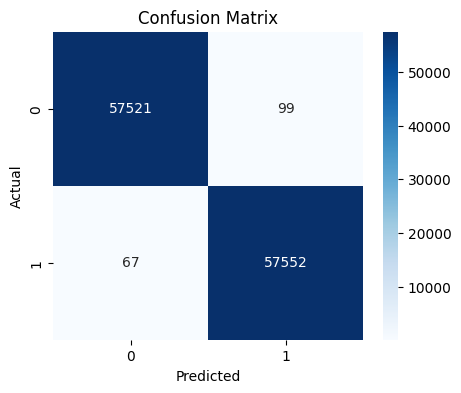

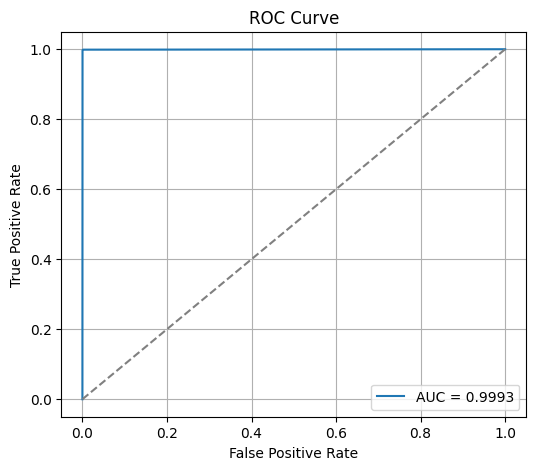

In [14]:
# Set model to evaluation mode
model.eval()

# Store predictions and true labels
y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        y_probs.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert outputs to predicted class (threshold = 0.5)
y_probs = torch.tensor(y_probs).numpy()
y_pred = (y_probs > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)

print("\nCNN Evaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Get model size and inference time
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")
    return size_mb

def measure_inference_time(model, loader):
    model.eval()
    total_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)

            if device.type == 'cuda':
                torch.cuda.synchronize()

            start_time = time.time()
            _ = model(inputs)

            if device.type == 'cuda':
                torch.cuda.synchronize()

            end_time = time.time()

            total_time += (end_time - start_time)
            total_samples += batch_size

    avg_time_per_sample = total_time / total_samples

    print(f"\nInference Speed Results:")
    print(f"Total samples processed : {total_samples}")
    print(f"Total inference time    : {total_time:.4f} seconds")
    print(f"Average time per sample : {avg_time_per_sample * 1000:.4f} ms")

In [16]:
# CNN model size and inference time
print(f"Model size: {get_model_size(model):.4f} MB")
measure_inference_time(model, test_loader)

Model size: 0.0048 MB

Inference Speed Results:
Total samples processed : 115239
Total inference time    : 1.1694 seconds
Average time per sample : 0.0101 ms
